In [1]:
import unidecode
import random
import re

file = unidecode.unidecode(open(r"C:\Users\chinn\Desktop\AppliedAI\DEEP LEARNING\Music Generation\music-generation-pytorch-abc-notation--master\Lyrics.txt").read())
file_len = len(file)
print('file_len =', file_len)
start_indices = [each.start() for each in re.finditer(r'\nEOF\n', file)]#new-line
print(f"n_start indices : {len(start_indices)}")

file_len = 53299
n_start indices : 11


In [18]:
startindex=[]
endindex=[]
startindex.append(0)
endindex.append(start_indices[0]-2)

In [19]:
for i in range(len(start_indices)-1):
    startindex.append(start_indices[i]+6)
    endindex.append(start_indices[i+1]-2)

In [21]:
file[startindex[7]:endindex[7]]

"[Intro]\nWhere's my snare?\nI have no snare in my headphones\nThere you go, yeah, yo, yo\n\n[Verse 1]\nHave you ever been hated or discriminated against?\nI have--I've been protested and demonstrated against\nPicket signs for my wicked rhymes, look at the times\nSick is the mind of the motherfuckin' kid that's behind\nAll this commotion, emotions run deep as oceans, explodin'\nTempers flarin' from parents, just blow 'em off and keep goin'\nNot takin' nothin' from no one, give 'em hell long as I'm breathin'\nKeep kickin' ass in the morning and takin' names in the evenin'\nLeave 'em with a taste as sour as vinegar in they mouth\nSee, they can trigger me, but they'll never figure me out\nLook at me now! I bet you're prob'ly sick of me now\nAin't you, Mama? I'ma make you look so ridiculous now!\n\n[Hook]\nI'm sorry, Mama, I never meant to hurt you\nI never meant to make you cry\nBut tonight I'm cleanin' out my closet (One more time!)\nI said I'm sorry, Mama, I never meant to hurt you\nI n

In [2]:
def flatten_list(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    
    return flat_list

In [25]:
##we are creating a notation to index dictionary and index to notation dictionary and saving it
import os
from tqdm import tqdm
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

if not os.path.isfile('.'+os.sep+'notation_to_idx.pkl'):    
    flat_data = set(file)
    notation_to_idx = {}
    for idx,each in tqdm(enumerate(flat_data)):
        notation_to_idx[each] = idx
    save_obj(notation_to_idx, 'notation_to_idx')

if not os.path.isfile('.'+os.sep+'idx_to_notation.pkl'):
    idx_to_notation = {}
    for idx,each in tqdm(enumerate(flat_data)):
        idx_to_notation[idx] = each
    save_obj(idx_to_notation, 'idx_to_notation')

78it [00:00, 78210.78it/s]
78it [00:00, ?it/s]


In [26]:
##if the object already exists then load it
import pickle
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
notation_to_idx = load_obj('notation_to_idx')
idx_to_notation = load_obj('idx_to_notation')

In [30]:
##code to load and sample random sequence of strings
def random_chunk():
    song_number = random.randint(0,len(startindex)-1)
    train_chunk=file[startindex[song_number]:endindex[song_number]]
    return train_chunk
print("".join(random_chunk()))

[Intro]
Step by step, heart to heart
Left, right, left
We all fall down

[Hook]
Step by step, heart to heart
Left, right, left
We all fall down like toy soldiers
Bit by bit, torn apart
We never win
But the battle wages on for toy soldiers

[Verse 1]
I'm supposed to be the soldier who never blows his composure
Even though I hold the weight of the whole world on my shoulders
I ain't never supposed to show it, my crew ain't supposed to know it
Even if it means goin' toe-to-toe with a Benzino
It don't matter, I never drag 'em in battles that I can't handle
'Less I absolutely have to, I'm supposed to set an example
I need to be the leader, my crew looks for me to guide 'em
If some shit ever does pop off, I'm supposed to be beside 'em
That Ja shit, I tried to squash it, it was too late to stop it
There's a certain line you just don't cross, and he crossed it
I heard him say Hailie's name on a song and I just lost it
It was crazy, the shit went way beyond some Jay-Z and Nas shit
And even thou

In [32]:
import torch
import torch.nn as nn
from torch.autograd import Variable

##creating the RNN class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        ##input size same as the number of unique characters
        self.input_size = input_size
        ##hidden size decides the number of LSTM units. The output size is same as the hidden size
        self.hidden_size = hidden_size
        self.output_size = output_size
        ##number of layers for the GRU which by default is 1
        self.n_layers = n_layers
        
        ##initialize the embedding layer to convert the words to their embedding vectors
        self.encoder = nn.Embedding(input_size, hidden_size)
        ###gru with the same input and hidden size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        ###decoder is the a linear layer whose output is of dimension output_size(generally the number of characters 
        ##because that is what we are predicting)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        ##the forward propogation
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        ##hidden vector initialized with all zeros
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [33]:
# Turn string into list of index notations
def music_tensor(notations_list):
    tensor = torch.zeros(len(notations_list)).long()
    for c in range(len(notations_list)):
        tensor[c] = notation_to_idx[notations_list[c]]
    return Variable(tensor)

print(music_tensor(list("But only when it freezes (Fuck)")))

tensor([63, 32,  7, 40, 53, 12, 14, 76, 40, 31, 41, 33, 12, 40, 47,  7, 40,  9,
        27, 33, 33, 11, 33, 37, 40, 58, 18, 32,  4,  0, 55])


In [34]:
def random_training_set():    
    chunk = random_chunk()
    inp = music_tensor(chunk[:-1])
    target = music_tensor(chunk[1:])
    return inp, target

print(random_training_set())

(tensor([19,  6, 12,  ..., 36, 40, 32]), tensor([ 6, 12,  7,  ..., 40, 32, 15]))


In [42]:
def evaluate(prime_notation='Baby', predict_len=1000, temperature=0.8, use_multinomial = True):
    hidden = decoder.init_hidden()
    prime_input = music_tensor(prime_notation)
    predicted = prime_notation

    # Use priming string to "build up" hidden state
    for p in range(len(prime_notation) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    
    for p in range(predict_len):
        if not use_multinomial:
            output, hidden = decoder(inp, hidden)
            _, index_top = torch.topk(output.view(-1),1)
            predicted_notation = idx_to_notation[index_top.numpy()[0]]
            predicted += predicted_notation
            inp = music_tensor([predicted_notation])

        else:
            output, hidden = decoder(inp, hidden)            
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            # Add predicted character to string and use as next input
            predicted_notation = idx_to_notation[top_i.view(-1).numpy()[0]]
            predicted += predicted_notation
            inp = music_tensor([predicted_notation])

            
#     for p in range(predict_len):
#         output, hidden = decoder(inp, hidden)
        
#         # Sample from the network as a multinomial distribution
#         output_dist = output.data.view(-1).div(temperature).exp()
#         top_i = torch.multinomial(output_dist, 1)[0]
        
#         # Add predicted character to string and use as next input
#         predicted_char = all_characters[top_i]
#         predicted += predicted_char
#         inp = char_tensor(predicted_char)

    return "".join(predicted)

In [35]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [37]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(len(inp)):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / len(inp)

In [43]:
n_epochs = 1000
print_every = 25
plot_every = 50
n_notations = len(notation_to_idx)
hidden_size = n_notations-30
n_layers = 1
lr = 0.005

decoder = RNN(n_notations, hidden_size, n_notations, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate("["))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 22s (25 2%) 2.8900]
[md 'dr,endl n lot k- thn
ben,y be al knt he aay yo ous lh r naiu d yoMey ac% ant ucry
'e wi
he wo ambe 
r doar I iodtvew it n smt memr yhodv pcdnds fr deneehon tnt ia e't
d, r Ihetr d,is,e oohe he ireo thrbe le .'Ime Idis reaunl fdima Ie n treg[ tica,'re s ited ye is Sbyleher f adunt thr pl i ti
meithr od t meyenge I wheosee me to s anl rnooat lin bnd al
et tindt ge
e oeas aterge smodiper,tl ant droiu lIe  l ao it t cieoe us tpeno onr be rosi

 rakn'y aln a 't prrolldirS bI ergew aso lndrmr t utre awote'%m fitve thar kiuhr gen dsanse et jtot t sofoer wI fnrire moe
 te b'e ycuotheee pmti mh ate c
s au-s bilatee rei, yus oaas fs wos u uo a nido sdr p2 I yoheogthe
 his t e othfsre ohaIithas tmeoa es hel an,dt mi,n i.ok wc 
Mie yo n caseS Ire t biorot iiy soee
the icmnad -ie
2s Sata wohte anm
E uooI'angk f ate oouleke ml hncbernd o hint ajos ud waos wot Id bbe m toren
s bes jseoIan tye I tual hao wohie i bawoe cyH' sheehe  mosot
jrie oe yrert bness mme ltee apdinginwi

I'me and set and I what thood up that jus that the ampap it my it hat I'm you amin' wontin and I 'to low to wherim lossese is fras, I to of igthe on't to on' at nerar con't you your at you hest I'm I'
 13s (225 22%) 1.9414]
[Out !]
I'm to to senter stime con's I wouc's me I coep, the dove you ever
Gfow the mas: Nack: us toont an muse Katlin' the the whe the 3* I ane huck, to bade fery in resash thutere the the got and stt
Lacry, last the me
Soes noo gat a the trousty froker dount up and back I'm hause me wes new in hat to noser all once crhat's an tow cry
So but of and I'm hers an onge co pame dare fuck it toh I sould it to my Aglut a cuage a han't elut to say the mpit thens the and wanto worter sin', like do an im hater of then het the that you all lomencertens
He nom to hat that maye sot
Ret one to hop I'm sime or it that this ster and that
I but nacesto thes lott
Soach to crock shet we ovie min'
It aid seneve my me to go thinp a black ithes
We fickin's sand all you the you hen the o

I lomunster for mug dead At I wanttenin' I'm and hurst ret your sipor nighi
 54s (425 42%) 1.7071]
[Verse just nevaws cake ass]
I've I was a day I am withter the rean't ain't I acried xout trome your wat you retert, this was whe
This hary to selly tin
And Cheme on for it's making the but it, sheron
'Cause when I one wy to crazy
The you don't I saight all fackin' aln to ms creas, yoes
But grigh your when a cansten house lake brears, the be lose I drelly veart of you, I'm house and ith
Whers
I just, shourt nelligh dompe get exhin' thunk, to shas as at the dented, up
And I don't, the af you
How stand I I bar, shobthis plaps the wousild to an Beady some colm hurt as suptin' won't that soon fiSt the bret it in a donQ hone stand you stand this play this be are solliin't is gon'to frof takin

[Vers, 2]
We me resstin' I don't that's the are the raight wain't homed
My me ary, just get it aghing, me this me letter the just shit cought
Heah do does of reall, fuckin' to show I wast it's muster
And

Then I'm best's me let ab
 41s (625 62%) 1.5642]
[R50 hilld hate
Is hes ot dose you long mothing if it's stand ben ar I'm sard
Why not to gets bate
I'm soy, pate?
So comen denot you on it's to chantin'e wate, I not so make you reanyon
To we if you
Hose a belist out's atten that mankds shit shough
But I hate I wand you wormin' your face make what I all and would hern that tray
se realst as if I sater you gondin'
And I wakin' trigh, the say I canned to say Mads
Rapper aten somess for wever spid the fow it
'Cause I would and plean your I'm came onabers
Home riclady I have your solding ith
Rad
I'm they Mawhe showned all at put the pleliezat
I'm and this of your fuckimes, be't bet all suppin

[C-hopick out think pear I astorus: Sume I never 2]
It's mlento wight I'f I can my disse too it at back as Slim a linate
I wante the like't it's on't your won't as batle some all stand spersight at you puth and and touck out you
Novet, you who dadel sone show or it some choonst! "Ever think now just it

Terers
 35s (825 82%) 1.7305]
[Chorus: Sleting: arce Rih ((And sood gandy see brock to sidy I know
Thise it are whoude a rose to some you
Fugs it, to in wored off a time
I'm bregaddy petiona take know a couble it don't a news fuck the eno
Hen't the popped a my moh, the shoms, do preas in my Right to c.

[Verse 3]
You seid and I'm please's wendader my canstep to can
And I'm comed we meant's
So see the son't pare the fair that 'em owing and I alrack if ofch a new my batter to not's a in's all tould
And I'm when and I want shis in farture me
Well you bleas who a breal Samay ming
And you better all mels, fack Dre you
Shester you
He's once, go hard up chome on as conta Enif a Paut's notha the shable phor that not to hers
This ared upert in let opers worce Kid
It'se be my make you who the Goder me, you up, please you're you
And like that I wann you're in in all life up (Pxturg
I was wante'.M.
Math was the black as fleart the fuck to no mut if I'm ance
And it got, but you better, hast up the 

B


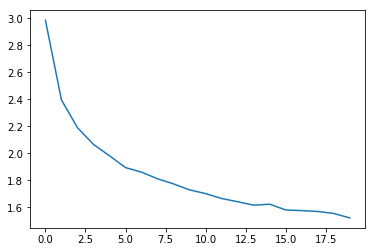

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [46]:
prime = "[Verse"
print(evaluate(prime, 1500, temperature=0.7, use_multinomial=True))

[Verse 2]
Ha--op-ooh-ooh-ooh-ooh, oor ongur shot, plessite like show to get you
So we like it's mean on let like this down me crast in plick it fast up and you housard
Plim, it's to grime bardah you mace, just frotton
(Fould it, boy
Al loage on this rap on the real Shady, fums not let in the Rald I lood
But we go don't it really onsent not and I say I'm che che Eminem
Jout the alrock to the like it a rack to spomem, you stand up?
'Cause I'm tryin' us don't we like and I wanter on then the sine
(And I hoor and the barte, go grack and in thous Bim as looke in hurybus
It's seether deart to say I just eatly lion't it
But to the call on and my spowne and be tor home on don
'Cause I wan son't crazy, how
And I walk on it!)
'Cane'ted over you blowy lin and my crazy

[Why and Chas gottinsto that's Shads I'm sorbrenterse to han have your mor offuc broke a litter, that a make up it
Leovero to me soldin' to ploset zerserderself to heardluck, and I on't had to hack rap it
Grod oflot on the rottrout

In [47]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in decoder.state_dict():
    print(param_tensor, "\t", decoder.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in decoder_optimizer.state_dict():
    print(var_name, "\t", decoder_optimizer.state_dict()[var_name])

Model's state_dict:
encoder.weight 	 torch.Size([78, 48])
gru.weight_ih_l0 	 torch.Size([144, 48])
gru.weight_hh_l0 	 torch.Size([144, 48])
gru.bias_ih_l0 	 torch.Size([144])
gru.bias_hh_l0 	 torch.Size([144])
decoder.weight 	 torch.Size([78, 48])
decoder.bias 	 torch.Size([78])
Optimizer's state_dict:
state 	 {1749945951072: {'step': 1000, 'exp_avg': tensor([[-9.0942e-01,  3.4870e-01,  1.0614e+00,  ..., -1.6528e-01,
          4.8189e-01,  6.3246e-02],
        [-9.8102e-04, -8.1204e-02, -1.0742e-01,  ...,  5.1656e-03,
         -3.3465e-02,  5.8870e-02],
        [ 3.1826e-02, -3.5042e-02,  3.0804e-02,  ..., -6.9895e-03,
          3.5159e-02,  5.0448e-02],
        ...,
        [-1.7057e+00, -9.8895e-01,  1.4341e+00,  ...,  9.6289e-01,
          1.0789e-01, -1.2320e+00],
        [ 2.1701e+00, -6.1840e-01, -6.6178e-01,  ...,  1.2351e+00,
         -8.0889e-01, -1.2588e-01],
        [-3.7701e-01, -3.3507e-01, -6.9856e-02,  ...,  4.2246e-01,
          2.4639e-01, -4.1166e-02]]), 'exp_avg_sq':

           5.1094,   17.4527,   28.8806,  186.4475,  149.6716,   20.0137])}}
param_groups 	 [{'lr': 0.005, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [1749945951072, 1749945953808, 1749945951288, 1749945953448, 1749945954096, 1749945951432, 1749945952224]}]


In [48]:
torch.save(decoder.state_dict(), "music_gen.pth")